In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/nlp-getting-started/')

# 데이터 로드

In [2]:
# 단순한 데이터 로드(메모리 절약 신경안쓸 때)
test = pd.read_csv('train.csv', encoding='utf-8')
# memory_usage()는 byte단위로 메모리 사용량 추출
# megabyte = 2의 20승 byte
print(f"Memory Usage: {test.memory_usage().sum()/1024**2 :.3f}MB")
test.head()

Memory Usage: 0.291MB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# 칼럼별 메모리 사용량 나옴
test.memory_usage()

Index         128
id          60904
keyword     60904
location    60904
text        60904
target      60904
dtype: int64

In [4]:
# 수치형 dtype 값을 줄여줌으로써 메모리 낭비 방지
# dtype에 dict형태 인자로 넣어줄 수 있음
# 이 때, DataFrame의 칼럼별 dtype은 numpy array이기 때문에 np 붙여주기
df_train = pd.read_csv('train.csv', encoding='utf-8',
                      dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('test.csv', encoding='utf-8',
                     dtype={'id': np.int16, 'target': np.int8})

print(f"dtype 수정 후 메모리 사용량: {df_train.memory_usage().sum()/1024**2 : .3f}MB")

dtype 수정 후 메모리 사용량:  0.196MB


- dtype 수정 후 0.1 메가바이트가 줄어듦!

# Keyword and Location feature

## 결측치

In [5]:
# keyword and location 결측치가 Train, Test 데이터에서의 비율 살펴보기
train_rows = df_train.shape[0]
null_train_keyword = df_train.isnull().sum()[1]
null_train_location = df_train.isnull().sum()[2]

test_rows = df_test.shape[0]
null_test_keyword = df_test.isnull().sum()[1]
null_test_location = df_test.isnull().sum()[2]

null_train_keyword_ratio = (null_train_keyword/train_rows) * 100
null_train_location_ratio = (null_train_location/train_rows) * 100
null_test_keyword_ratio = (null_test_keyword/test_rows) * 100
null_test_location_ratio = (null_test_location/test_rows) * 100

print(f"Train 데이터 keyword 결측치 비율: {null_train_keyword_ratio:.2f}%")
print(f"Train 데이터 location 결측치 비율: {null_train_location_ratio:.2f}%")
print()
print(f"Test 데이터 keyword 결측치 비율: {null_test_keyword_ratio:.2f}%")
print(f"Test 데이터 location 결측치 비율: {null_test_location_ratio:.2f}%")

Train 데이터 keyword 결측치 비율: 0.80%
Train 데이터 location 결측치 비율: 33.27%

Test 데이터 keyword 결측치 비율: 0.80%
Test 데이터 location 결측치 비율: 33.86%


- Train, Test 각 데이터에서 결측치 비율이 거의 동일한 것으로 보아 **``결측치가 모두 같은 샘플에서 생성되었음을 추론할 수 있음!!``**

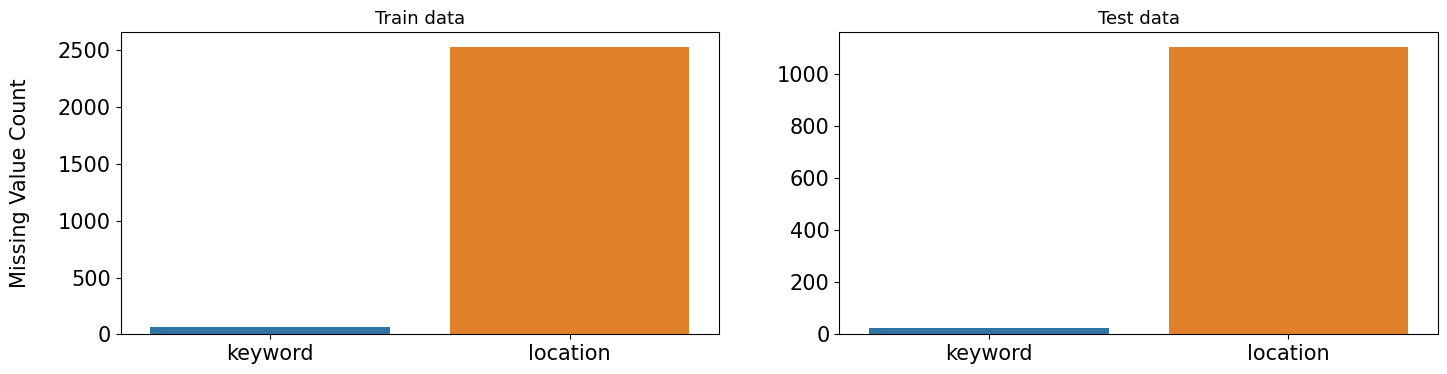

In [6]:
# Train, Test 데이터에서 각 결측치 비율 시각화
# 그리고 결측치를 특정 값들로 각각 대체
import matplotlib.pyplot as plt
import seaborn as sns

missing_cols = ['keyword', 'location']
# dpi는 그래프 크기 조절하는 인자
# inch * dpi = Pixel 단위공식
fig, axes = plt.subplots(figsize=(17,4), ncols=2, dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index,
           y=df_train[missing_cols].isnull().sum().values,
           ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index,
           y=df_test[missing_cols].isnull().sum().values,
           ax=axes[1])
# 각 그래프 축 외관 수정과 축이름 설정
axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20) #labelpad: 축과 축label 사이의 공간 지정
    # 축 외관수정하는 tick_params함수. axis에 'x'축인지 'y'축인지 설정하기
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

# 그래프 제목 설정
axes[0].set_title('Train data', fontsize=13)
axes[1].set_title('Test data', fontsize=13)
plt.show()

# 반복문 통해서 결측치 특정값으로 대체
dfs = [df_train, df_test]
for df in dfs:
    for col in missing_cols:
        # f string 활용해서 칼럼 이름 문자 포함하는 결측치 대체값 설정
        df[col] = df[col].fillna(f"no_{col}")

- **``Cardinality가 높다 = 중복도가 낮다``**

- location은 자동으로 생성되는 값들이 아닌 사용자들이 임의대로 만들어 내는 값들이기 때문에 지저분하고 유니크한 값들이 너무 많다. 따라서 적절한 feature는 아님

- keyword의 unique한 값 개수를 Train, Test 데이터에서 비교해보고 활용할 만한 feature인지 찾아보자. 

In [7]:
print(f"Number of unique values in keyword= {df_train['keyword'].nunique()} (Training)")
print(f"Number of unique values in keyword= {df_test['keyword'].nunique()} (Training)")
print()
print(f"Number of unique values in location= {df_train['location'].nunique()} (Training)")
print(f"Number of unique values in location= {df_test['location'].nunique()} (Training)")

Number of unique values in keyword= 222 (Training)
Number of unique values in keyword= 222 (Training)

Number of unique values in location= 3342 (Training)
Number of unique values in location= 1603 (Training)


- keyword는 unique한 값들이 Train, Test 데이터에서 개수가 **동일**하다
- 따라서 텍스트에 추가하던지 기타 방법으로 적절한 Feature로 사용 가능!

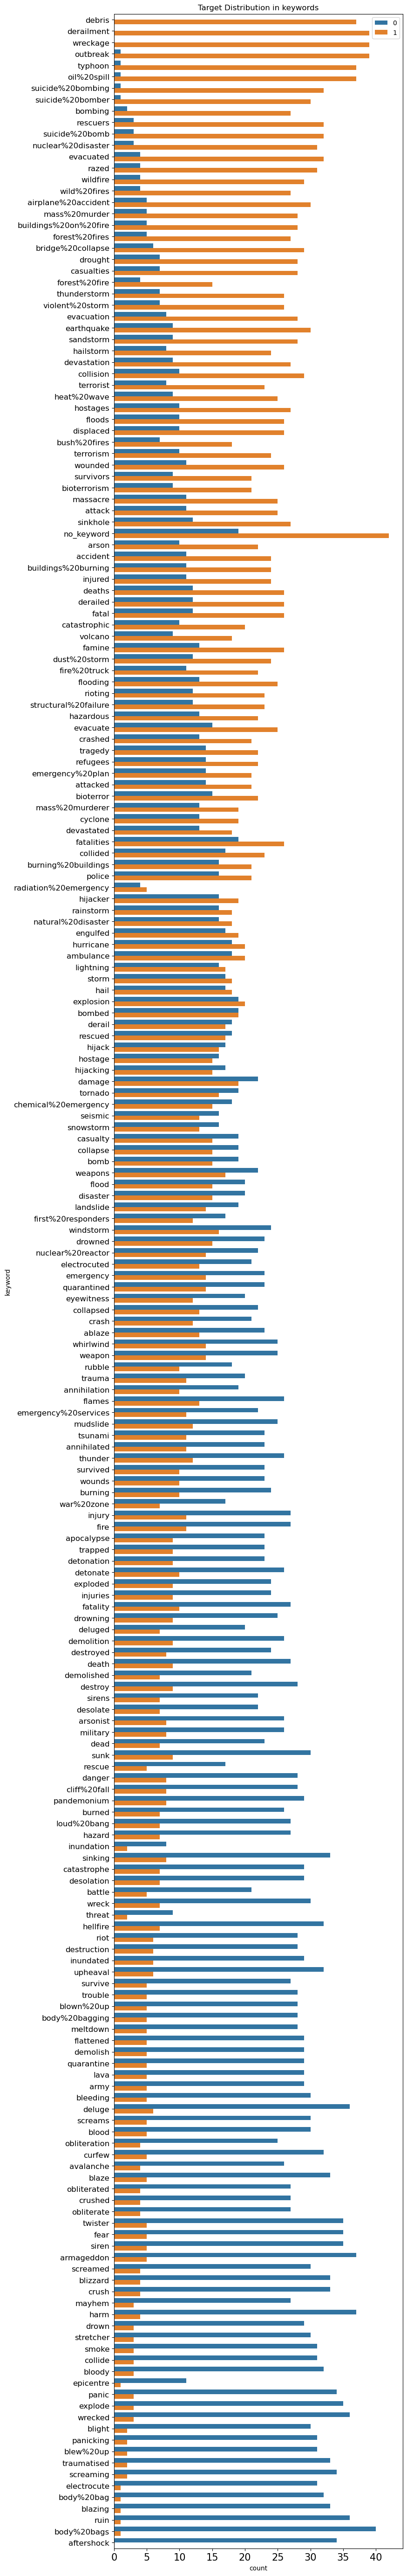

In [8]:
# Keyword 별로 Target 평균값 살펴보기
# 즉, Keyword 별로 disaster tweet인지 아닌지 관찰 가능

# group by 집계함수로 transform 함수도 있음, agg(dict)랑 동일!
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

# keyword별 disaster tweet 여부 빈도수 집계
sns.countplot(y=df_train.sort_values(by='target_mean',ascending=False)['keyword'],
           hue=df_train.sort_values(by='target_mean',ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
# loc=1='upper right'
plt.legend(loc=1)
plt.title('Target Distribution in keywords')
plt.show()

# target_mean 변수 삭제
df_train = df_train.drop('target_mean', axis=1)


# Meta features

- Disaster tweet은 non-disaster tweet보다 더 긴 단어를 사용해 공식적인 표현방법으로 쓰였을 것이고 더 적은 글자수(typo)를 가질 것이다. 이러한 분석을 위한 Meta feature들을 만들어 정의해보자.<br><br>

    - word_count: number of words in text
    - unique_word_count: number of unique words in text
    - stop_word_count:  number of stop words in text
    - url_count number: of urls in text
    - mean_word_length: average character count in words
    - char_count number: of characters in text
    - punctuation_count: number of punctuations(구두점) in text
    - hashtag_count: number of hashtags (#) in text
    - mention_count: number of mentions (@) in text

In [9]:
# word_count : 텍스트에 들어있는 단어 count 변수
# 텍스트를 string으로 만들어주고, split() 디폴트는 공백을 기준으로 split
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_train['text'].apply(lambda x : len(str(x).split()))


---

``python의 set() 학습``

- 1.중복이 없다. 2.순서가 없다
- 우선 set()은 집합 관련 처리 자료인데, list, tuple과는 달리 순서가 없어 인덱싱으로는 특정 값을 추출이 불가하다. 그래서 list나 tuple로 바꾸어주어야 인덱싱 추출이 가능

In [10]:
# 교집합 구하기
a = set([1,2,3,4,5])
b = set([3,4,5,6,7])

print(a & b)
print(a.intersection(b))

{3, 4, 5}
{3, 4, 5}


In [11]:
# 합집합 구하기
print(a | b)
print(a.union(b))

{1, 2, 3, 4, 5, 6, 7}
{1, 2, 3, 4, 5, 6, 7}


In [12]:
# 차집합 구하기
print(a - b)
print(a.difference(b))

{1, 2}
{1, 2}


In [13]:
#### 두가지 방법 모두 뒤에 추가됨

# 1개 값 추가하기 -> add()
# 객체로 할당안해도 inplace됨
a.add(100)
print(a)

# 여러개값 추가하기 -> update([])
b.update([111,112,113])
print(b)

{1, 2, 3, 4, 5, 100}
{3, 4, 5, 6, 7, 111, 112, 113}


In [14]:
# 특정 값 삭제
a.remove(100)
print(a)

# 여러 값 삭제는 안 됨! 밑에처럼 리스트로 감싸도 안 됨!
# b.remove([111,112,113])

{1, 2, 3, 4, 5}


---

In [15]:
# unqiue_word_count: 텍스트에 들어있는 unique한 단어 count 변수(distince 값)
# set() 집함 함수로 unique한 값들 추출 가능
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

- wordcloud 라이브러리에도 STOPWORDS 사전 존재
- nltk에도 stopdwords 사전 존재
- 둘 중에 wordcloud 불용거 개수가 더 많음

In [16]:
# stop_word_count : 텍스트에서 불용어 개수 세기
from wordcloud import STOPWORDS

# 텍스트에서 불용어에 속하는 단어들의 개수 세는 list comprehension(텍스트 소문자화 시키기 잊지말기-불용어가 다 소문자로 되어있음)
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in STOPWORDS]))

In [17]:
# url_count : 텍스트에서 http 또는 https로 시작하는 단어 개수 세기
                                                                            #'특정문자열' in 단어..두 조건 이어붙이기 위해서 괄호안해도 됨
df_train['url_count'] = df_train['text'].apply(lambda x: len([url for url in str(x).lower().split() if 'http' in url or 'https' in url]))
df_test['url_count'] = df_train['text'].apply(lambda x: len([url for url in str(x).lower().split() if 'http' in url or 'https' in url]))

In [18]:
# mean_word_length : 텍스트에서 단어들의 평균 길이
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

In [19]:
# char_count : 텍스트 문자열 길이(공백 제외임!)
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

In [20]:
# string 라이브러리의 punctuation 함수 = 구두점 모아놓은 것
import string
print(type(string.punctuation))
print(string.punctuation)

<class 'str'>
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [21]:
# punctuaiton(구두점)_count
# 단어별 추출이 아닌 구두점만 추출해서 개수를 세기 때문에 문자열 split 안해도 됨!
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([word for word in str(x) if word in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([word for word in str(x) if word in string.punctuation]))


In [22]:
# hashtag_count : 해쉬태그(#) 개수 세기
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([word for word in str(x) if word == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([word for word in str(x) if word == '#']))


In [23]:
# mention_count : 누군가를 태그(언급)하는 @ 문자 개수 세기
df_train['mention_count'] = df_train['text'].apply(lambda x: len([word for word in str(x) if word == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([word for word in str(x) if word == '@']))


- 만든 meta feature들의 분포가 Train, Test 데이터에서 각각 어떻게 분포되는지 관찰하기
- 또한 Class값(disaster여부)에 따라 meta feature들의 분포가 어떻게 달라지는지도 관찰하기

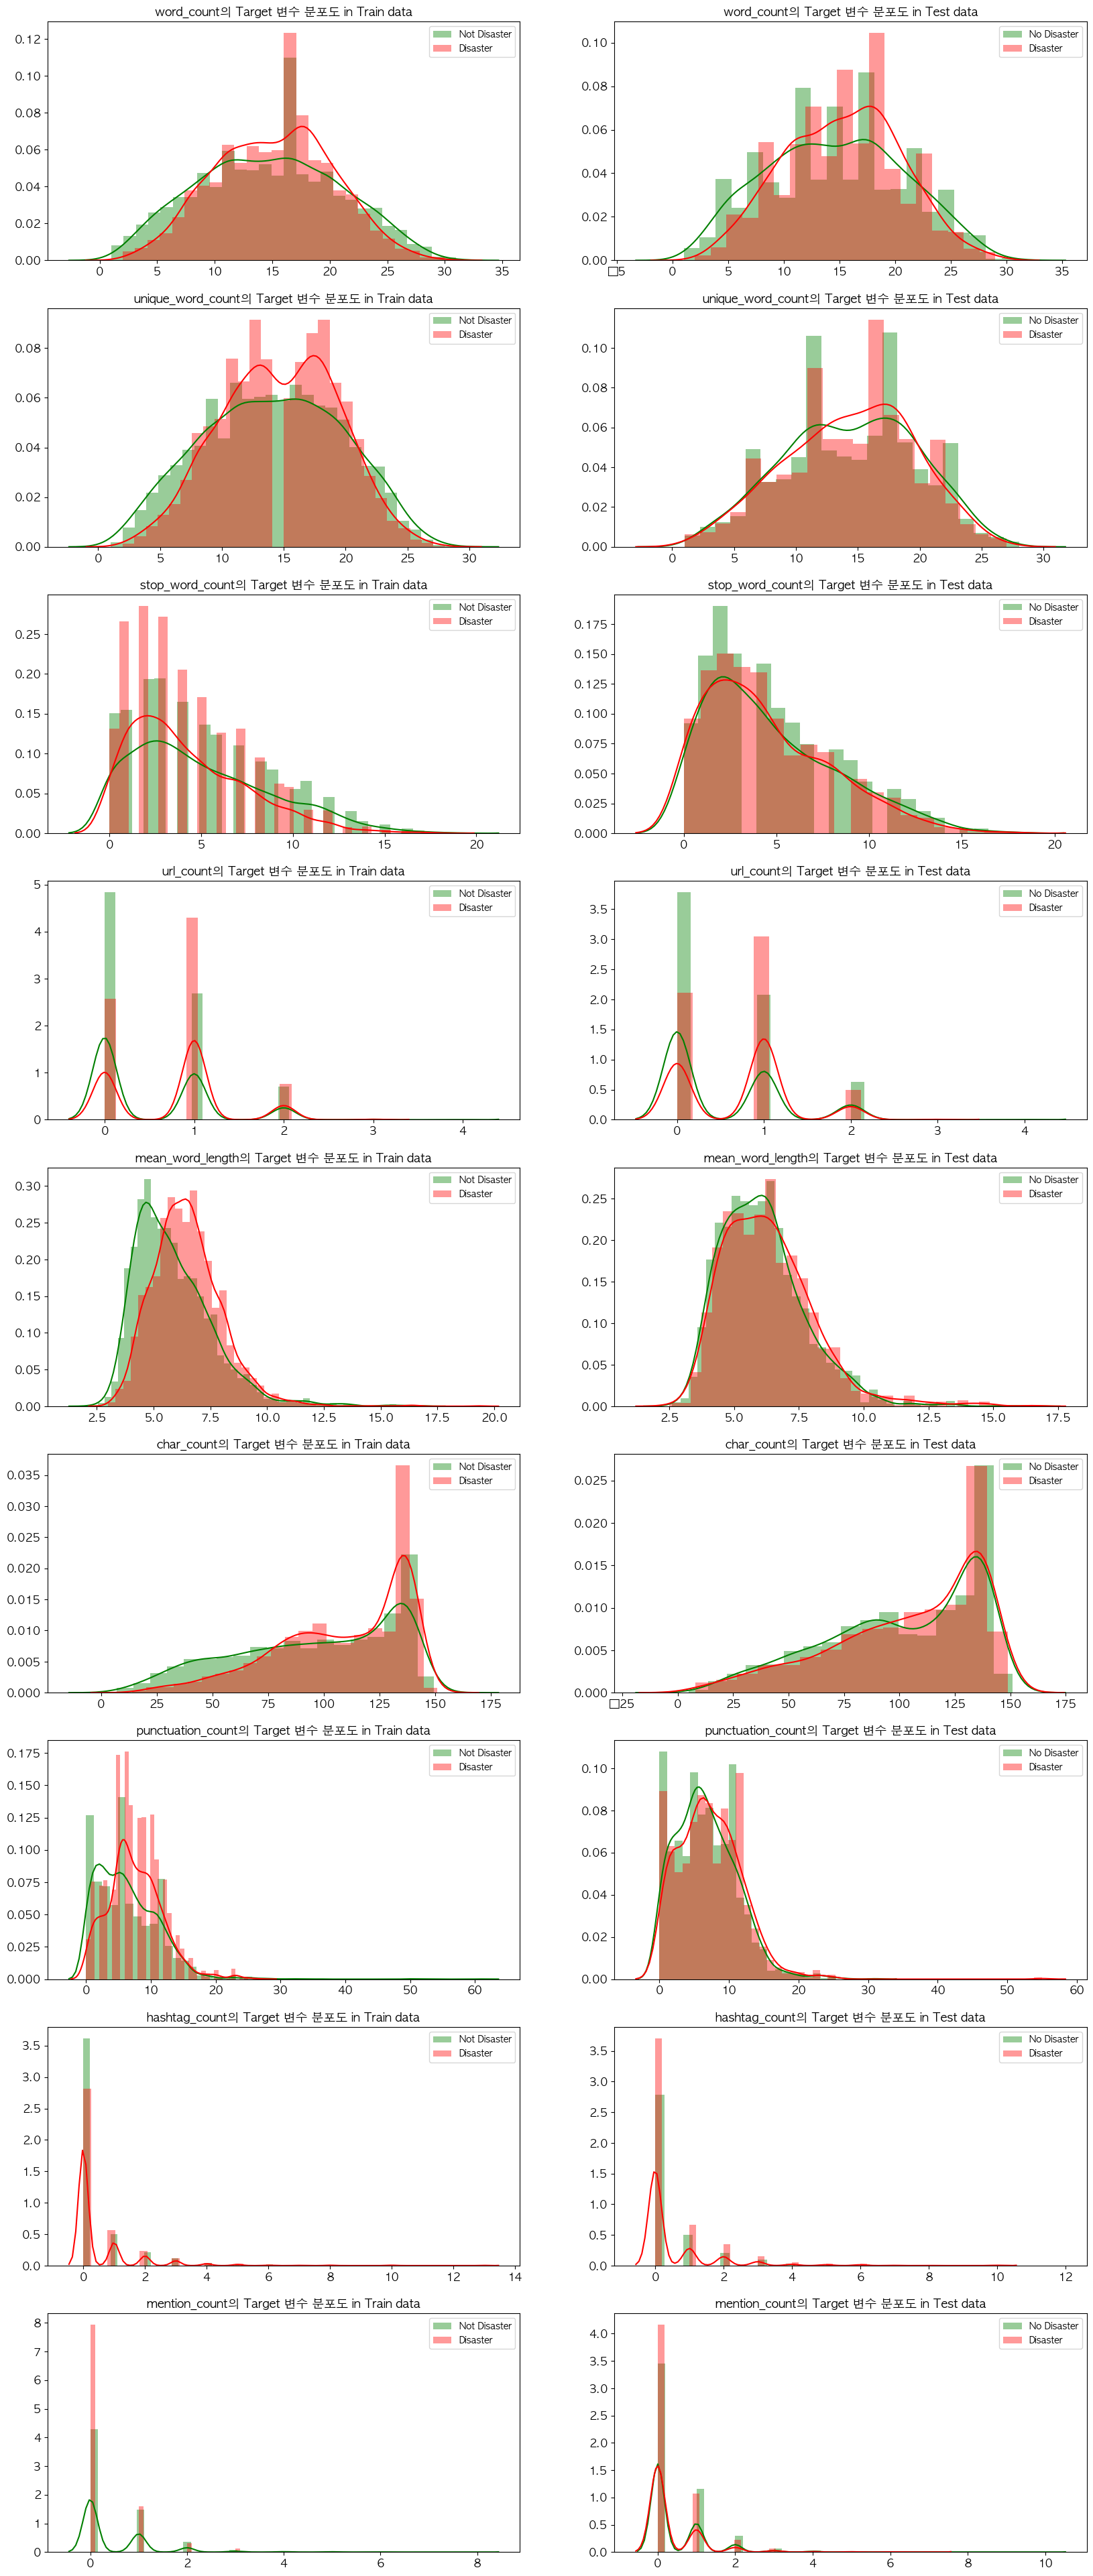

In [24]:
import warnings
warnings.filterwarnings(action='ignore')
plt.rc('font', family='AppleGothic')

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

# disaster 인 label 데이터만 추출하기 위해 boolean index 활용
disaster_row_boolean = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES),
                        figsize=(20,50), dpi=100)

# pandas의 loc안에는 boolean array가 들어갈 수 있다(True값들 행만 추출!)
for i, feature in enumerate(METAFEATURES):
    # Train data의 No-disaster/disaster 분포도 표현
    sns.distplot(df_train.loc[~disaster_row_boolean][feature],
                label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[disaster_row_boolean][feature],
                 label='Disaster', ax=axes[i][0], color='red')
    # Test data에도 동일하게 수행
    sns.distplot(df_test.loc[~disaster_row_boolean][feature],
                label='No Disaster', ax=axes[i][1], color='green')
    sns.distplot(df_test.loc[disaster_row_boolean][feature],
                label='Disaster', ax=axes[i][1], color='red')
    
    # 그래프 이름과 x,y축 글씨 크기 설정
    for j in range(2):
        # x축에 지저분하게 써져 있는 feature 이름 빈칸으로 대체
        axes[i][j].set_xlabel('')
        # x,y축 글씨 크기 늘리기
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        # disaster 여부 legend만들기
        axes[i][j].legend()
    
    axes[i][0].set_title(f"{feature}의 Target 변수 분포도 in Train data",
                        fontsize=13)
    axes[i][1].set_title(f"{feature}의 Target 변수 분포도 in Test data",
                        fontsize=13)

- 우선 모든 meta feature들 분포가 Train, Test 데이터에서 비슷한 분포모양을 띄므로 같은 모집단에서 추출한 sample들임을 알 수 있다.<br><br>
- url_count, hashtag_count, mention_count는 class값에 따라 차이점을 보여주기 힘든 분포이다.
- 위 변수들을 제외한 나머지 meta feature들은 class값에 따라 분포 차이가 존재하는 듯 하다(생김새로만 봤을 때..)

# Target and N-grams

In [25]:
total_class = len(df_train['target'])

In [26]:
# train 데이터 class imbalance 여부 확인
# 클래스 비율 살펴보기
df_train['target'].value_counts() / total_class

0    0.57034
1    0.42966
Name: target, dtype: float64

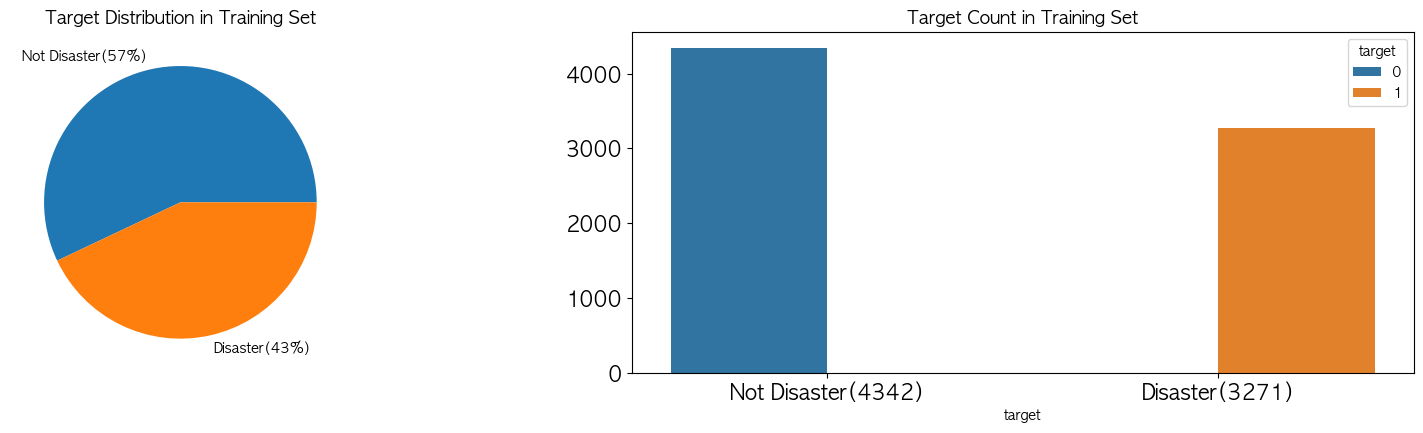

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie',
                                             ax=axes[0],
                                             labels=['Not Disaster(57%)',
                                                    'Disaster(43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'],
             ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster(4342)', 'Disaster(3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set',
                 fontsize=13)
axes[1].set_title('Target Count in Training Set',
                 fontsize=13)
plt.show()

In [28]:
def generate_ngrams(text, n_grams=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_grams)])
    return [' '.join(ngram) for ngram in ngrams]

---

In [29]:
test = df_train['text'][0]
# 리스트 컴프리헨션에서 조건 2개 붙일때는 그냥 옆에 바로 붙여 작성하면 됨
token = [token for token in test.lower().split(' ') if token != '' if token not in STOPWORDS]
# 이중리스트로 되어있는걸 unpack 시키고 zip시키기! 
ngrams = zip(*[token[i:] for i in range(2)])
# 다시 리스트로 담기
[' '.join(ngram) for ngram in ngrams]


['deeds reason',
 'reason #earthquake',
 '#earthquake may',
 'may allah',
 'allah forgive',
 'forgive us']

``zip함수에서 * operator의 의미``

In [30]:
# 리스트안에 리스트가 하나 더 묶여있어서(pack) 우리가 원하는 결과처럼 unpack하고 zip하지 않는다.
normal = [[1,2,3], [4,5,6]]
normal_zip = zip(normal)
for a in normal_zip:
    print(a)

([1, 2, 3],)
([4, 5, 6],)


In [31]:
# * operator를 붙여서 안에 있는 리스트를 unpack하고 zip시킴
asterisk_zip = zip(*normal)
for a in asterisk_zip:
    print(a)

(1, 4)
(2, 5)
(3, 6)


---

## defaultdict() 사용법

- defaultdict()는 기본적으로 ()안에 들어가는 자료형 타입을 특정 key에 대한 value를 주지 않으면 디폴트로 하는 것을 의미

- ()안에 들어가는 값 종류
    * int : 디폴트값이 0으로 들어감
    * list : 디폴트값이 빈 리스트로 들어감
    * set : 디폴트값이 빈 집합(set)으로 들어감. 참고로 set은 중복을 허용x

In [32]:
from collections import defaultdict
# 1.int
int_dict = defaultdict(int)

int_dict['key1']
int_dict['key2'] = 'value2'
int_dict

defaultdict(int, {'key1': 0, 'key2': 'value2'})

In [35]:
# 1.int 예제 - 문자열 종류 개수가 각각 몇개인지 셀 때!
text = 'itismydogsheismysister'
text_dict = defaultdict(int)

for k in text:
    text_dict[k] += 1
print(text_dict)

defaultdict(<class 'int'>, {'i': 4, 't': 2, 's': 5, 'm': 2, 'y': 2, 'd': 1, 'o': 1, 'g': 1, 'h': 1, 'e': 2, 'r': 1})


In [36]:
# 2.list 
list_dict = defaultdict(list)
list_dict['key1'] 
list_dict['key2'] = 'value2'
list_dict

defaultdict(list, {'key1': [], 'key2': 'value2'})

In [37]:
# 2.list 예제 - 각 성에 해당하는 이름들을 리스트로 만들 때
name_lst = [('jo', 'hun'), ('lee','bok'),('lee','kee'),
           ('park','hyuk'),('jo','sung')]
name_dict = defaultdict(list)

for k, v in name_lst:
    # defaultdict(list)에서 value부여 안해서 빈리스트 생성되는데 거기다가 append
    name_dict[k].append(v)
name_dict

defaultdict(list,
            {'jo': ['hun', 'sung'], 'lee': ['bok', 'kee'], 'park': ['hyuk']})

In [38]:
# 3.set
set_dict = defaultdict(set)
set_dict['key1'] 
set_dict['key2'] = 'value2'
set_dict

defaultdict(set, {'key1': set(), 'key2': 'value2'})

In [39]:
# 3.set 예제 - 중복값 없애고 싶을 때!
name_lst = [('jo', 'hun'), ('lee','bok'),('lee','kee'),
           ('park','hyuk'),('jo','hun')]
name_set = defaultdict(set)
#set요소에 첨가할 땐 add함수 사용하기!
for k, v in name_lst:
    name_set[k].add(v)
    
print(name_set)

defaultdict(<class 'set'>, {'jo': {'hun'}, 'lee': {'bok', 'kee'}, 'park': {'hyuk'}})


---

In [42]:
N = 100
### Unigram ###
# defaultdict이용해 value값 없으면 그 key의 value는 0으로 자동 부여
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

# disaster에 해당하는 텍스트를 하나씩 가져온 후 그 텍스트를 1gram시키기
# 1gram시켜서 반환된 리스트 요소를 하나씩 가져와서 그 요소를 key로하고 그 요소(단어)가 몇 번 출현했는지를 value로 담기
for tweet in df_train[disaster_row_boolean]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1

for tweet in df_train[~disaster_row_boolean]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

In [52]:
# dict.items()하면 한쌍의 key, value를 하나의 튜플로 담아서 리스트안에 전체 튜플 담아서 반환
# sorted()는 모든 자료구조를 정렬 가능, key인자로 정렬 기준을 설정 가능(lambda 사용))
# [::-1]로 내림차순으로 정렬
# 튜플 여러쌍이 담긴 리스트를 가지고 DataFrame으로 만들 수 있음!(첫 번째튜플요소끼리 첫번째 칼럼이 됨!)
df_disaster_unigram = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigram = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_disaster_unigram.head()

,0,1
0,-,389
1,fire,150
2,via,117
3,...,105
4,&amp;,105


In [53]:
#### Bigram ####
disaster_bigram = defaultdict(int)
nondisaster_bigram = defaultdict(int)

for tweet in df_train[disaster_row_boolean]['text']:
    for word in generate_ngrams(tweet, n_grams=2):
        disaster_bigram[word] += 1

for tweet in df_train[~disaster_row_boolean]['text']:
    for word in generate_ngrams(tweet, n_grams=2):
        nondisaster_bigram[word] += 1

df_disaster_bigram = pd.DataFrame(sorted(disaster_bigram.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigram = pd.DataFrame(sorted(nondisaster_bigram.items(), key=lambda x: x[1])[::-1])

### Trigram ###
disaster_trigram = defaultdict(int)
nondisaster_trigram = defaultdict(int)

for tweet in df_train[disaster_row_boolean]['text']:
    for word in generate_ngrams(tweet, n_grams=3):
        disaster_trigram[word] += 1

for tweet in df_train[~disaster_row_boolean]['text']:
    for word in generate_ngrams(tweet, n_grams=3):
        nondisaster_trigram[word] += 1

df_disaster_trigram = pd.DataFrame(sorted(disaster_trigram.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigram = pd.DataFrame(sorted(nondisaster_trigram.items(), key=lambda x: x[1])[::-1])

## Visualize the each N-gram

### Unigram

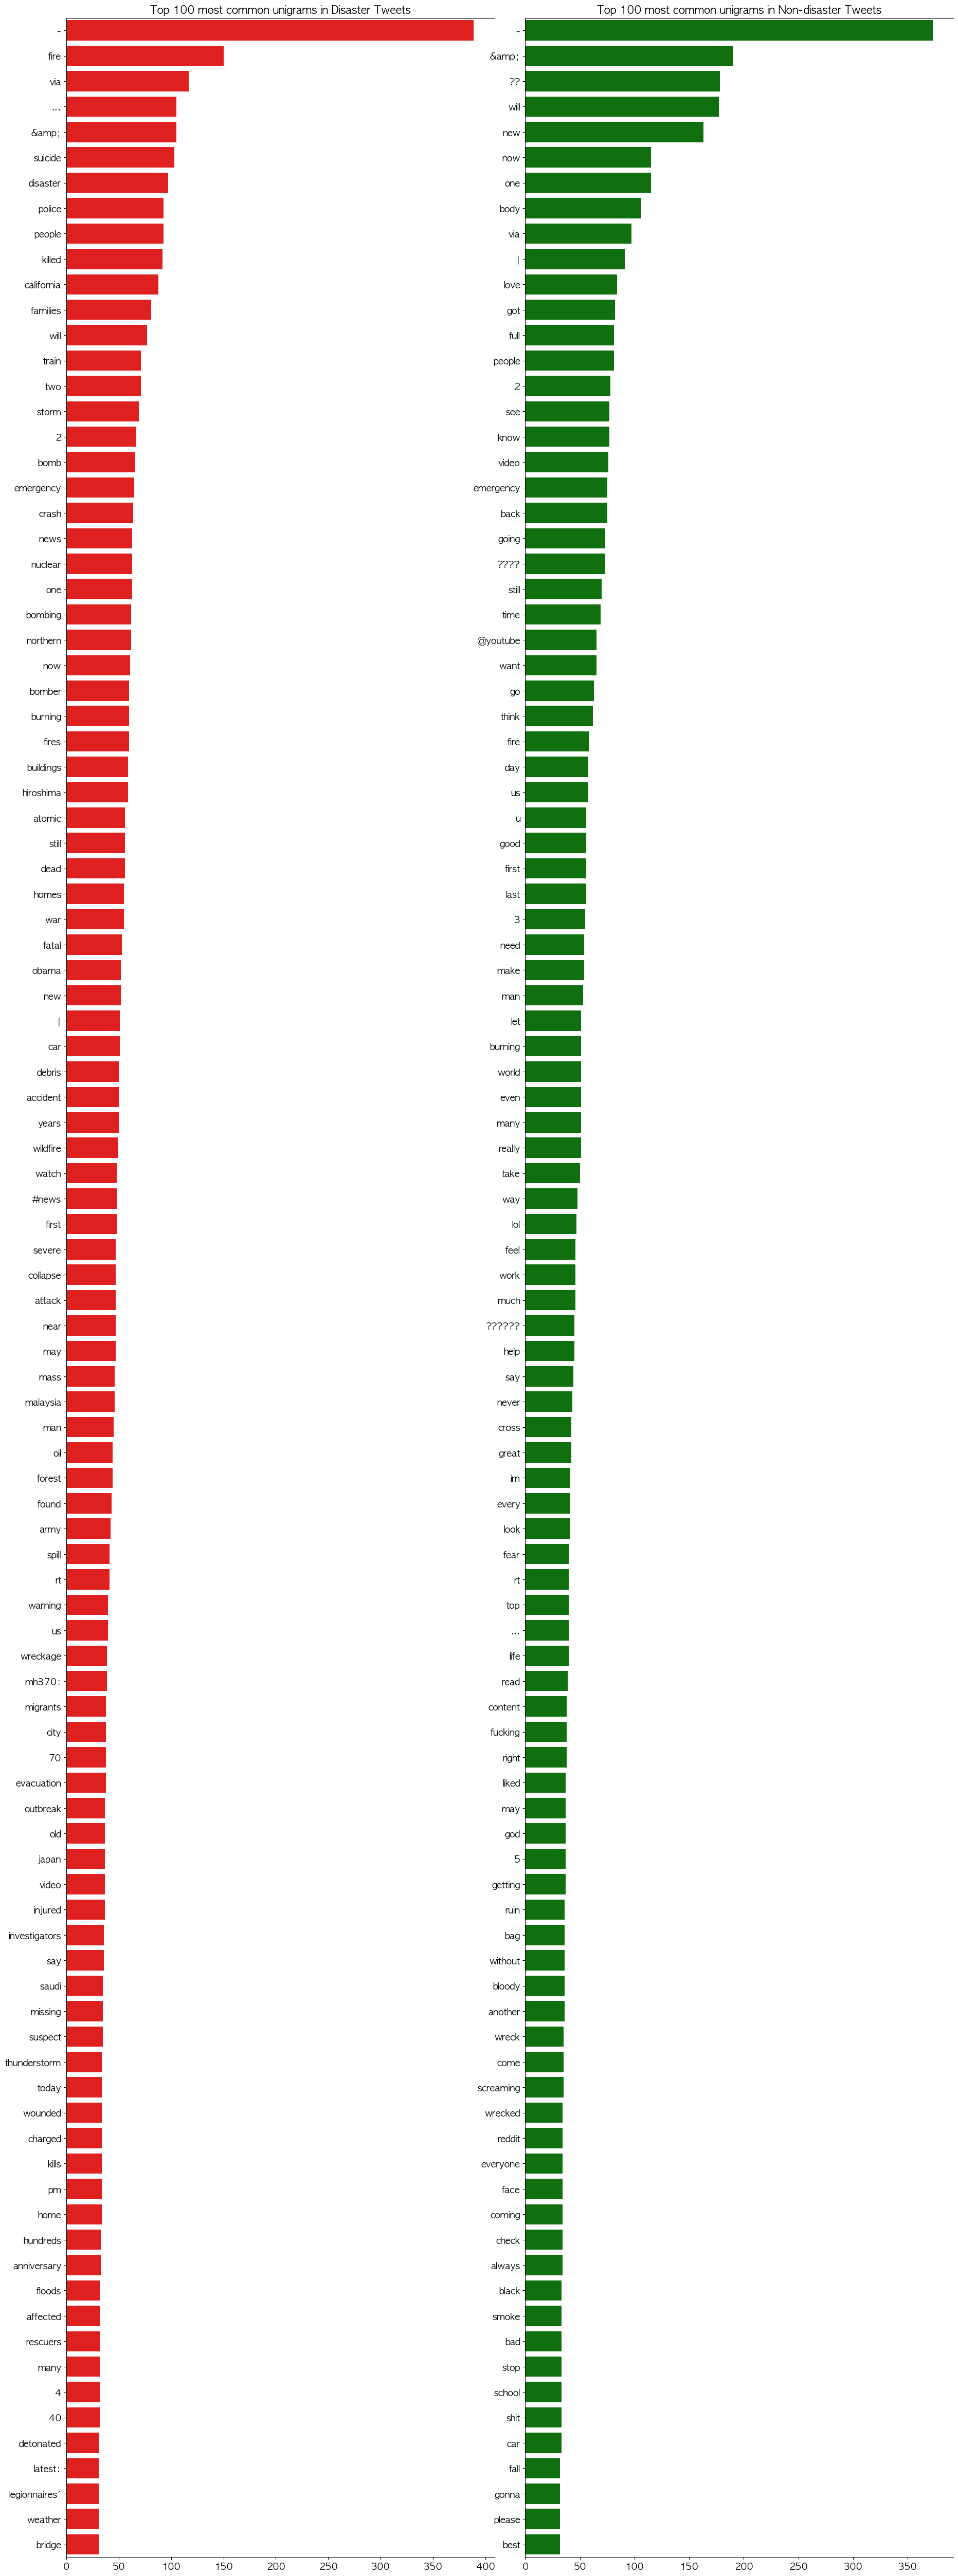

In [61]:
# Unigram 수행 후 가장 많이 사용된 단어 상위 100개 시각화
# disaster, Non-disaster 각각 시각화
N = 100
fig, axes = plt.subplots(figsize=(18,50), ncols=2, dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigram[0].values[:N],
           x=df_disaster_unigram[1].values[:N],
           ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigram[0].values[:N],
           x=df_nondisaster_unigram[1].values[:N],
           ax=axes[1], color='green')

for i in range(2):
    # spines로 축 선 표시 설정 - 오른쪽 선을 안보이게 설정
    axes[i].spines['right'].set_visible(False)
    # 축 자체의 label 초기화
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    # 축 tick의 label 설정
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f"Top {N} most common unigrams in Disaster Tweets",
                 fontsize=15)
axes[1].set_title(f"Top {N} most common unigrams in Non-disaster Tweets",
                 fontsize=15)
plt.show()

- 두 클래스 모두 구두점들이 가장 많이 존재한다. 이것은 종속변수에 영향을 주지 않으므로 모델링 전 삭제가 절대적으로 필요

- disaster 클래스에서 가장 많은 단어인 ``fire``은 이미 재난에 대한 정보를 주고 있다.

- non-disasteer 클래스에서는 가장 많이 사용한 단어가 동사인 ``will``이며 상위 단어에 동사가 많다. 이것은 왜냐하면 non-disaster에 해당하는 tweet대부분 개인 유저가 작성한 문장이고 이는 결국 격식이 없는(informal) 문장이기 때문

### Bigrams

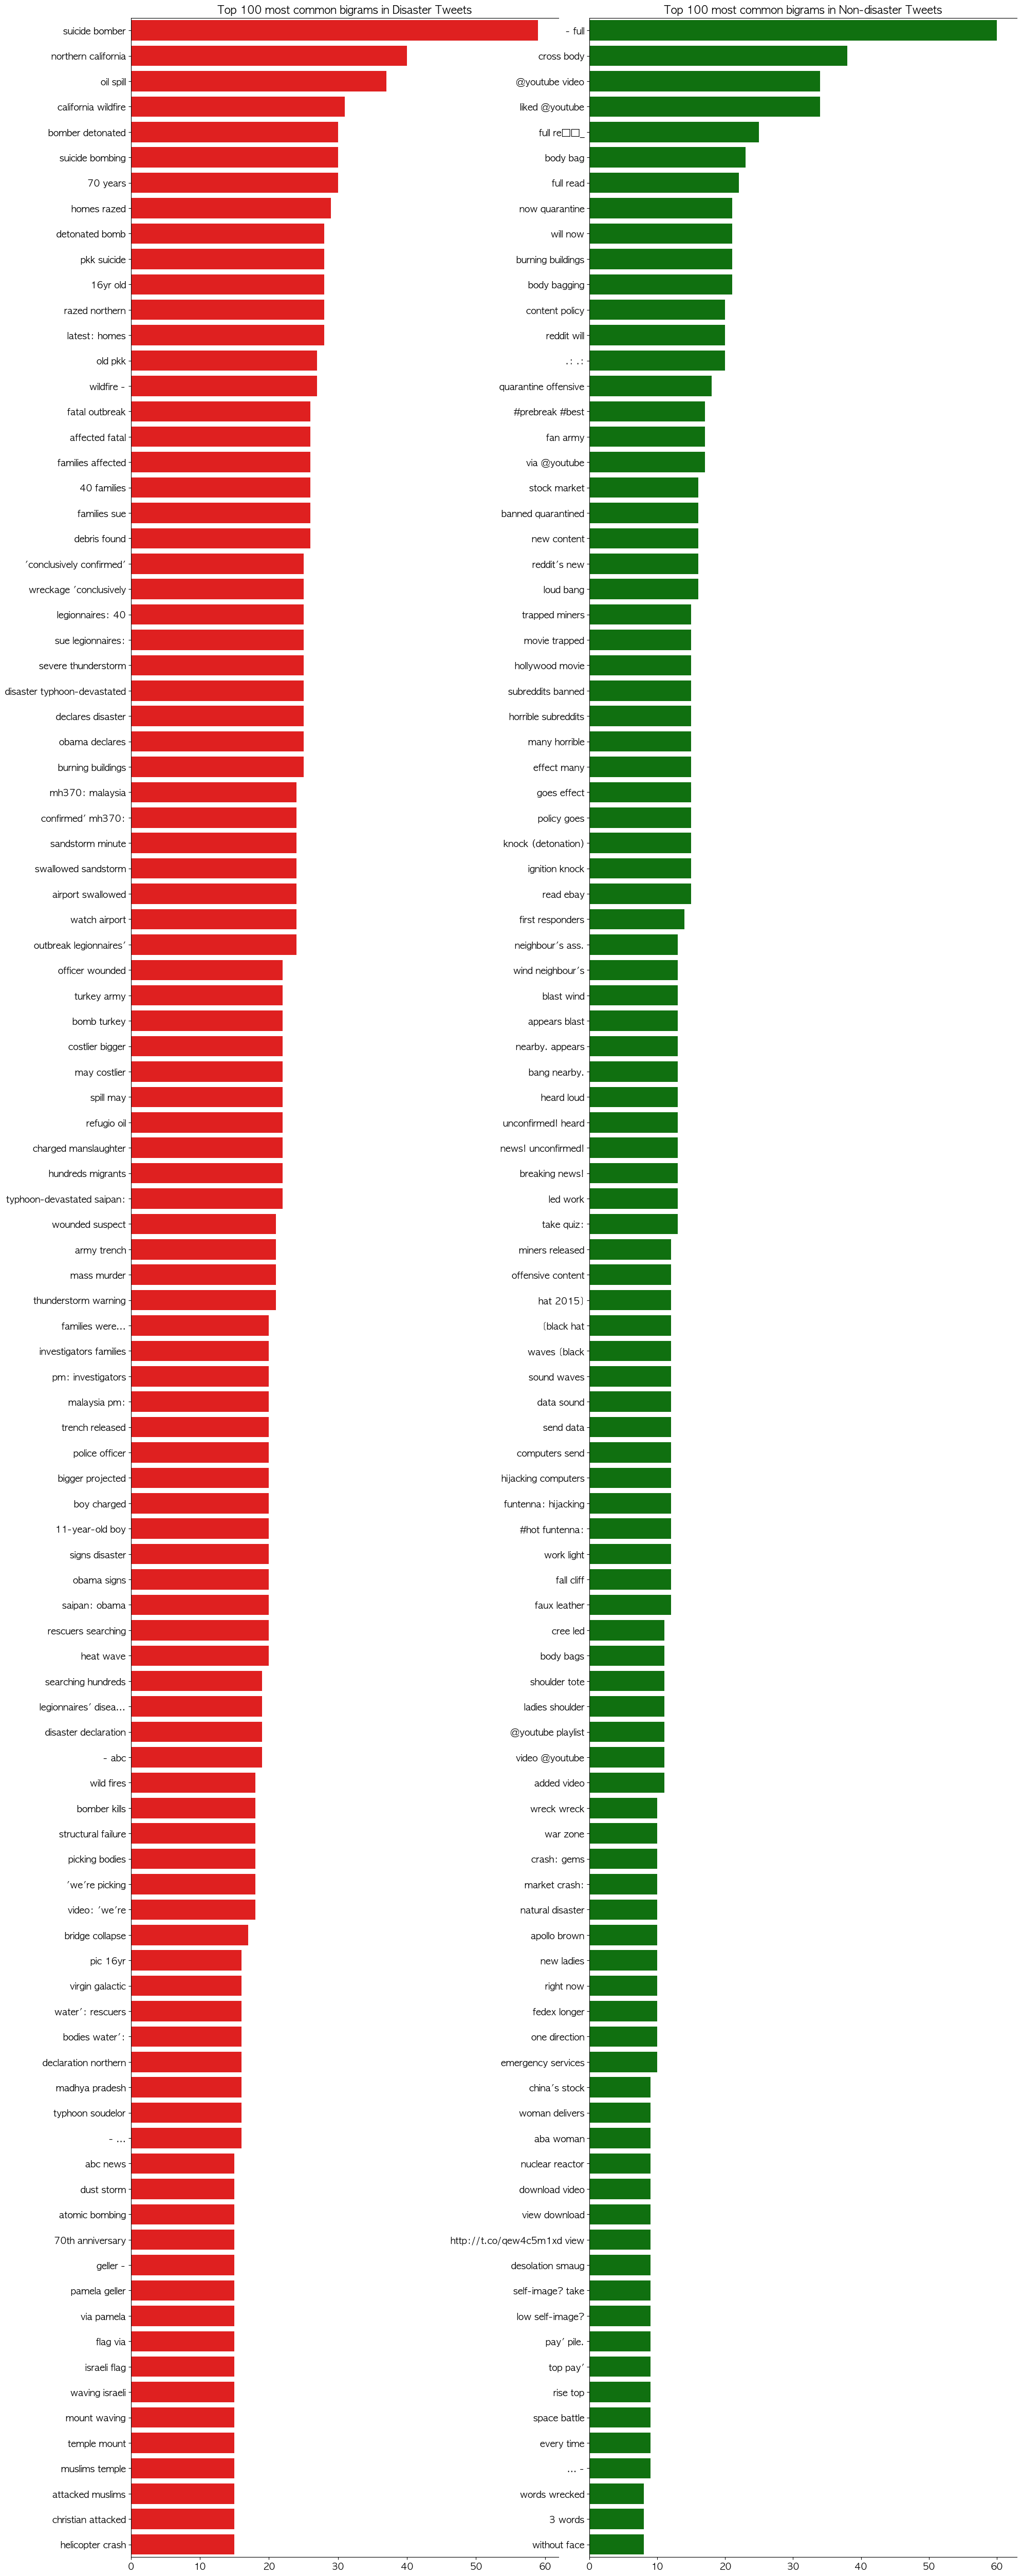

In [68]:
fig, axes = plt.subplots(figsize=(18,50), ncols=2, dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigram[0].values[:N],
           x=df_disaster_bigram[1].values[:N],
           ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigram[0].values[:N],
           x=df_nondisaster_bigram[1].values[:N],
           ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f"Top {N} most common bigrams in Disaster Tweets",
                 fontsize=15)
axes[1].set_title(f"Top {N} most common bigrams in Non-disaster Tweets",
                 fontsize=15)
plt.show()